In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dependencies
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# Importing the test database
twitter_df = pd.read_csv("test_database.csv")
twitter_df

,Unnamed: 0,text,dana_sentiment,dana_sarcasm,david_sentiment,david_sarcasm,keerti_sentiment,keerti_sarcasm,kevin_sentiment,kevin_sarcasm,sentiment_conflict,output
0,0,My daughters and I voted today for you....did ...,anti-gun,NaN,NaN,NaN,anti-gun,not sarcastic,NaN,NaN,NaN,anti-gun
1,1,SHAME on YOU @GregAbbott_TX ‼️How do you sleep...,anti-gun,NaN,NaN,NaN,anti-gun,not sarcastic,NaN,NaN,NaN,anti-gun
2,2,Greg Abbott can’t and won’t keep your kids saf...,anti-gun,NaN,NaN,NaN,anti-gun,not sarcastic,NaN,NaN,NaN,anti-gun
3,3,Caitlyne shares a name with my youngest\r\n\r\...,anti-gun,NaN,NaN,NaN,anti-gun,not sarcastic,NaN,NaN,NaN,anti-gun
4,4,Like millions of @MomsAGAbbott &amp; @MomsDema...,anti-gun,NaN,NaN,NaN,anti-gun,not sarcastic,NaN,NaN,NaN,anti-gun
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,St. Louis County mayors join Valentine in call...,NaN,NaN,anti-gun,not sarcastic,NaN,NaN,anti-gun,not sarcastic,NaN,anti-gun
96,96,#GunControlNow #GunControl It’s past due https...,NaN,NaN,anti-gun,not sarcastic,NaN,NaN,anti-gun,not sarcastic,NaN,anti-gun
97,97,@GalenMicheal In other parts of the world it t...,NaN,NaN,anti-gun,not sarcastic,NaN,NaN,anti-gun,not sarcastic,NaN,anti-gun
98,98,"What's #Measure114, you may wonder?\r\n\r\nMea...",NaN,NaN,neutral,not sarcastic,NaN,NaN,neutral,not sarcastic,NaN,neutral


In [5]:
# Drop irrelevant columns
twitter_df = twitter_df.drop(['dana_sentiment', 'dana_sarcasm', 'david_sentiment', 'david_sarcasm', 'keerti_sentiment', 'keerti_sarcasm', 'kevin_sentiment', 'kevin_sarcasm', 'sentiment_conflict'], axis=1)
twitter_df

,Unnamed: 0,text,output
0,0,My daughters and I voted today for you....did ...,anti-gun
1,1,SHAME on YOU @GregAbbott_TX ‼️How do you sleep...,anti-gun
2,2,Greg Abbott can’t and won’t keep your kids saf...,anti-gun
3,3,Caitlyne shares a name with my youngest\r\n\r\...,anti-gun
4,4,Like millions of @MomsAGAbbott &amp; @MomsDema...,anti-gun
...,...,...,...
95,95,St. Louis County mayors join Valentine in call...,anti-gun
96,96,#GunControlNow #GunControl It’s past due https...,anti-gun
97,97,@GalenMicheal In other parts of the world it t...,anti-gun
98,98,"What's #Measure114, you may wonder?\r\n\r\nMea...",neutral


In [6]:
# Data information
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  100 non-null    int64 
 1   text        100 non-null    object
 2   output      100 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [7]:
# Length of the dataset
print("Length of the data is", len(twitter_df))

Length of the data is 100


In [8]:
# Checking for null values
np.sum(twitter_df.isnull().any(axis=1))

0

In [9]:
# Calculate the count of different sentiment types
sentiment_counts = twitter_df.groupby(['output']).size()
print(sentiment_counts)

output
anti-gun    58
neutral     25
pro-gun     17
dtype: int64


<AxesSubplot:>

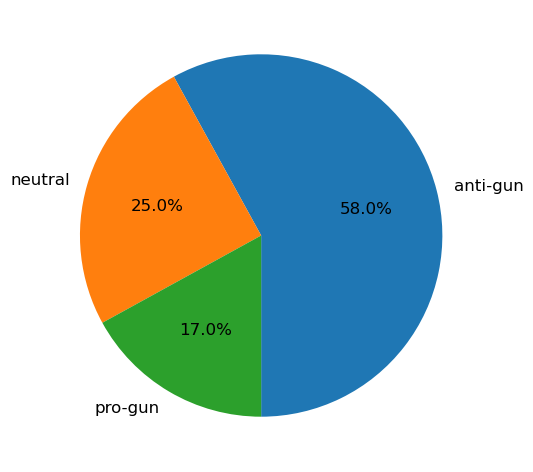

In [10]:
# Plot twitter sentiment on pie chart
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

In [11]:
# Function to clean the database
def preprocess_tweet(tweet):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    tweet = tweet.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ", tweet)

    # Remove special characters
    tweet = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", tweet)

    # Single character removal
    tweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', tweet)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    return tweet

In [12]:
# Save cleaned tweets in new cleaned column
cleaned_tweets = []

for tweet in twitter_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

twitter_df['cleaned'] = pd.DataFrame(cleaned_tweets)
twitter_df.head(10)

,Unnamed: 0,text,output,cleaned
0,0,My daughters and I voted today for you....did ...,anti-gun,my daughters and voted today for you did you v...
1,1,SHAME on YOU @GregAbbott_TX ‼️How do you sleep...,anti-gun,shame on you tx how do you sleep at nite 19 de...
2,2,Greg Abbott can’t and won’t keep your kids saf...,anti-gun,greg abbott can and won keep your kids safe tx...
3,3,Caitlyne shares a name with my youngest\r\n\r\...,anti-gun,caitlyne shares name with my youngest if could...
4,4,Like millions of @MomsAGAbbott &amp; @MomsDema...,anti-gun,like millions of amp voters in texas am sick a...
5,5,Never forget #Uvalde #BetoForGovernor https://...,anti-gun,never forget uvalde betoforgovernor
6,6,@AbbottCampaign @GregAbbott_TX But they don’t ...,anti-gun,tx but they don matter in uvalde and they cer...
7,7,We’ve obtained never before seen body cam vide...,anti-gun,we ve obtained never before seen body cam vide...
8,8,A reminder that there’s no bottom to the depra...,anti-gun,a reminder that there no bottom to the depravi...
9,9,"Mass shootings, like in a #StLouisHighSchool ,...",anti-gun,mass shootings like in stlouishighschool uvald...


In [13]:
# Drop column text
twitter_df = twitter_df.drop(twitter_df.columns[[0, 1]], axis=1)
twitter_df

,output,cleaned
0,anti-gun,my daughters and voted today for you did you v...
1,anti-gun,shame on you tx how do you sleep at nite 19 de...
2,anti-gun,greg abbott can and won keep your kids safe tx...
3,anti-gun,caitlyne shares name with my youngest if could...
4,anti-gun,like millions of amp voters in texas am sick a...
...,...,...
95,anti-gun,st louis county mayors join valentine in call ...
96,anti-gun,guncontrolnow guncontrol it past due
97,anti-gun,in other parts of the world it takes months t...
98,neutral,what measure114 you may wonder measure 114 wou...


In [14]:
# Defining set containing all stopwords in English
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma', 'may',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
             'st', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'tx', 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [15]:
# Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
twitter_df['cleaned'] = twitter_df['cleaned'].apply(lambda text: cleaning_stopwords(text))
twitter_df.head()

,output,cleaned
0,anti-gun,daughters voted today vote uvalde abortionrigh...
1,anti-gun,shame sleep nite 19 dead school children 2 dea...
2,anti-gun,greg abbott keep kids safe txlege uvalde abbot...
3,anti-gun,caitlyne shares name youngest could say anythi...
4,anti-gun,like millions amp voters texas sick tired worr...


In [16]:
# Cleaning and removing URL's
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
twitter_df['cleaned'] = twitter_df['cleaned'].apply(lambda x: cleaning_URLs(x))
twitter_df.head()

,output,cleaned
0,anti-gun,daughters voted today vote uvalde abortionrigh...
1,anti-gun,shame sleep nite 19 dead school children 2 dea...
2,anti-gun,greg abbott keep kids safe txlege uvalde abbot...
3,anti-gun,caitlyne shares name youngest could say anythi...
4,anti-gun,like millions amp voters texas sick tired worr...


In [17]:
# Cleaning and removing Numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
twitter_df['cleaned'] = twitter_df['cleaned'].apply(lambda x: cleaning_numbers(x))
twitter_df.head()

,output,cleaned
0,anti-gun,daughters voted today vote uvalde abortionrigh...
1,anti-gun,shame sleep nite dead school children dead t...
2,anti-gun,greg abbott keep kids safe txlege uvalde abbot...
3,anti-gun,caitlyne shares name youngest could say anythi...
4,anti-gun,like millions amp voters texas sick tired worr...


In [18]:
# Getting tokenization of tweet text
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")
twitter_df['cleaned'] = twitter_df['cleaned'].apply(tokenizer.tokenize)
twitter_df.head()

,output,cleaned
0,anti-gun,"[daughters, voted, today, vote, uvalde, aborti..."
1,anti-gun,"[shame, sleep, nite, dead, school, children, d..."
2,anti-gun,"[greg, abbott, keep, kids, safe, txlege, uvald..."
3,anti-gun,"[caitlyne, shares, name, youngest, could, say,..."
4,anti-gun,"[like, millions, amp, voters, texas, sick, tir..."


In [19]:
# Applying Stemming
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
twitter_df['cleaned'] = twitter_df['cleaned'].apply(lambda x: stemming_on_text(x))
twitter_df.head()

,output,cleaned
0,anti-gun,"[daughters, voted, today, vote, uvalde, aborti..."
1,anti-gun,"[shame, sleep, nite, dead, school, children, d..."
2,anti-gun,"[greg, abbott, keep, kids, safe, txlege, uvald..."
3,anti-gun,"[caitlyne, shares, name, youngest, could, say,..."
4,anti-gun,"[like, millions, amp, voters, texas, sick, tir..."


In [20]:
# Applying Lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
twitter_df['cleaned'] = twitter_df['cleaned'].apply(lambda x: lemmatizer_on_text(x))
twitter_df.head()

,output,cleaned
0,anti-gun,"[daughters, voted, today, vote, uvalde, aborti..."
1,anti-gun,"[shame, sleep, nite, dead, school, children, d..."
2,anti-gun,"[greg, abbott, keep, kids, safe, txlege, uvald..."
3,anti-gun,"[caitlyne, shares, name, youngest, could, say,..."
4,anti-gun,"[like, millions, amp, voters, texas, sick, tir..."


In [21]:
# Separating input feature and label
X=twitter_df.cleaned
y=twitter_df.output

In [22]:
# Splitting our dataset into Train and Test Subset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
# Transforming Dataset using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x)))
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  1705


In [24]:
X_train = vectorizer.transform(X_train.apply(lambda x: ' '.join(x)))
X_test  = vectorizer.transform(X_test.apply(lambda x: ' '.join(x)))